In [ ]:
!pip install mesh_to_sdf pyrender trimesh
!pip install torch torchvision
!pip install git+https://github.com/facebookresearch/pytorch3d.git@v0.2.0
!pip install celluloid
!pip install tqdm

In [ ]:
pip install celluloid

***Импорт библиотек***


In [44]:
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from tqdm import tqdm_notebook

from celluloid import Camera

import torch

from pytorch3d.utils import ico_sphere

from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

from pytorch3d.io import load_obj

from pytorch3d.ops import sample_points_from_meshes

from pytorch3d.structures import Meshes, Textures

from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)

import trimesh
from trimesh import registration
from trimesh import visual


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  torch.cuda.set_device(device)
else:
  device = torch.device('cpu')

****Подготовка моделей****


In [49]:
!mkdir data
!wget -nc -P ./data/ https://raw.githubusercontent.com/basarab1504/ml/main/12140_Skull_v3_L2.obj
path_to_model = os.path.join("data", "12140_Skull_v3_L2.obj")

mkdir: cannot create directory ‘data’: File exists
File ‘./data/12140_Skull_v3_L2.obj’ already there; not retrieving.



In [50]:
verts, faces_idx, _ = load_obj(path_to_model)
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the chair.
work_M = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:484: UserWarning: Mtl file does not exist: data/12140_Skull_v3_L2.mtl
  warnings.warn(f"Mtl file does not exist: {f_mtl}")


# Новый раздел

In [51]:
sphere_mesh = ico_sphere(0, device)

verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

# Rainbow sphere in pytorch3d
# verts_rgb = torch.rand_like(sphere_mesh.verts_list()[0])[None]

sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

In [52]:
num_points_to_sample = 25000

work_V, work_N = sample_points_from_meshes(
    work_M,
    num_points_to_sample ,
    return_normals=True
)

sphere_vert, sphere_norm = sample_points_from_meshes(
    sphere_mesh,
    num_points_to_sample,
    return_normals=True
)

In [53]:
def convert_to_mesh(mesh):
    """Trimesh может загружать сцены вместо монолитного объекта
    """
    if isinstance(mesh, trimesh.Scene):
        return mesh.dump(concatenate=True)
    else:
        return mesh
    
def scale_to_unit(mesh: trimesh.Trimesh):
    length, weight, height = mesh.extents
    scale = 1 / max(length, weight, height)
    mesh.apply_scale((scale, scale, scale))

***Рендеринг полигональных моделей***

In [54]:
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a directional light in the scene. 
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(
        device=device, 
        cameras=cameras, 
        lights=lights
        )
)

# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

In [55]:
work_I = phong_renderer(meshes_world=work_M, R=R, T=T)
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

image_sphere = image_sphere.cpu().numpy()
work_I = work_I.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


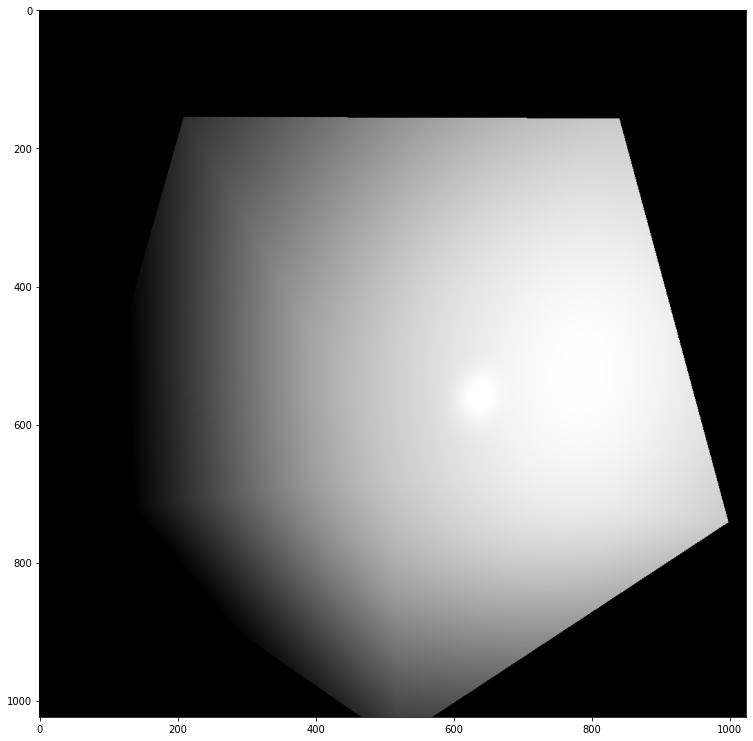

In [56]:
plt.figure(figsize=(13, 13))
plt.imshow(image_sphere.squeeze())
plt.grid(False)

***

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


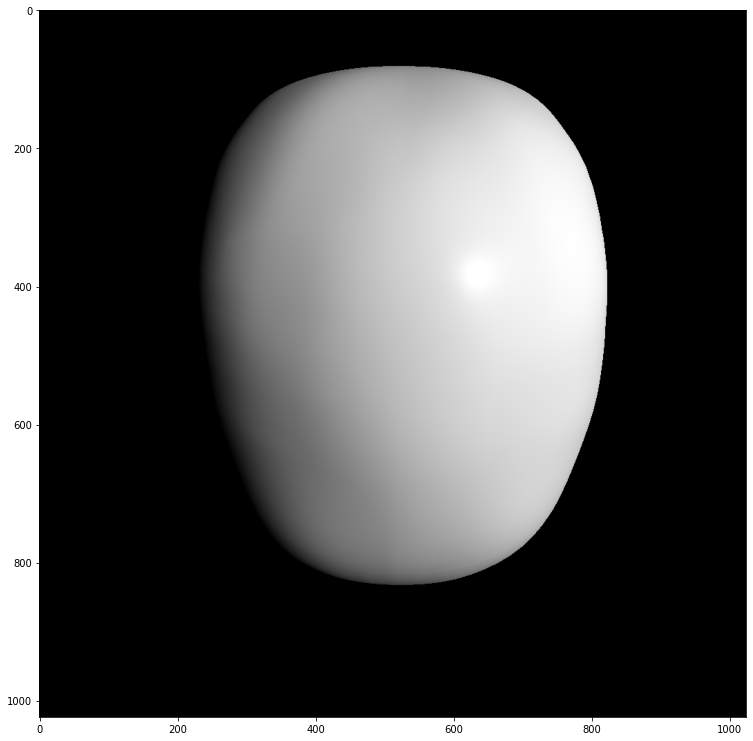

In [57]:
plt.figure(figsize=(13, 13))
plt.imshow(work_I.squeeze())
plt.grid(False)